<a href="https://colab.research.google.com/github/carson-edmonds/AAI-521-Sports-Image-Classification/blob/main/SundayLatestVersion-not-trainable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Apendix A

Pre-processing

In [1]:
!pip install -q kaggle
!pip install -q patool

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 1.1 MB/s eta 0:00:00


In [2]:
# Not all imports are used but thought it was important to show all the different
# approaches tried and experimented with.
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import requests
from PIL import Image
from io import BytesIO
import random
import pickle
from sklearn.model_selection import train_test_split
import patoolib

# Data visualization
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub


# Keras
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Dropout, Flatten, Resizing
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Scaling data
from sklearn.preprocessing import StandardScaler
# Classification Report
from sklearn.metrics import classification_report
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from google.colab import files
from google.colab.patches import cv2_imshow

In [ ]:
## THIS WILL TRIGGER A UPLOAD BUTTON LOOKING FOR THE KAGGLE KEY
# upload kaggle.json that was generated from kaggle when getting api key
files.upload()

# creates and unzips dataset on google drive /content folder
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d rishikeshkonapure/sports-image-dataset/
! mkdir kaggle_data
! unzip /content/sports-image-dataset.zip -d kaggle_data

##Appendix B

Building Classification with Resnet50_v2_50 model

Resnet does get rescaled 1/255

efficientNet does not require image rescale - if we had time this is another model we could look into

ResNet50 works best with input images of 224 x 224

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
data_dir = '/content/kaggle_data/data'

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                                labels='inferred',
                                                                image_size=IMAGE_SIZE,
                                                                validation_split=0.2,
                                                                label_mode= 'categorical',
                                                                subset="both",
                                                                batch_size=BATCH_SIZE,
                                                                #  color_mode="grayscale"
                                                                seed=58)



categories = train_ds.class_names
# Viewing the shape and object of the

def inspect_dataset(dataset, name="train"):
  print("Dataset:", name)
  for image_batch, labels_batch in dataset:
    print("image batch size", image_batch.shape)
    print("label batch shape ", labels_batch.shape)
    print("label batch", labels_batch[0])
    print("\n ")
    break

inspect_dataset(train_ds, "TRAIN")
inspect_dataset(val_ds, "VALIDATION")

Found 14184 files belonging to 22 classes.
Using 11348 files for training.
Using 2836 files for validation.
Dataset: TRAIN
image batch size (32, 224, 224, 3)
label batch shape  (32, 22)
label batch tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(22,), dtype=float32)

 
Dataset: VALIDATION
image batch size (32, 224, 224, 3)
label batch shape  (32, 22)
label batch tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(22,), dtype=float32)

 


In [ ]:
# Creating spliting test / validation datasets
test_val_ds = val_ds.take(int(0.7 * len(val_ds)))
val_ds = val_ds.skip(int(0.7 * len(val_ds)))
inspect_dataset(test_val_ds, "TEST")
inspect_dataset(val_ds, "NEW VALIDATION")


AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Dataset: TEST
image batch size (32, 224, 224, 3)
label batch shape  (32, 22)
label batch tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(22,), dtype=float32)

 
Dataset: New validation
image batch size (32, 224, 224, 3)
label batch shape  (32, 22)
label batch tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(22,), dtype=float32)

 


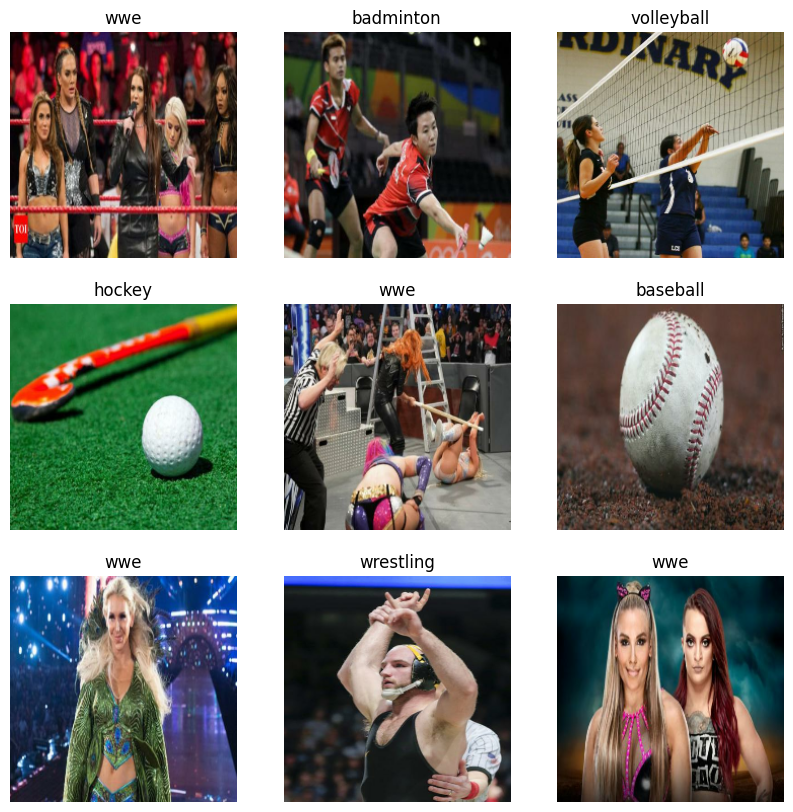

In [ ]:
def display_img(train_ds):
  class_names = train_ds.class_names
  plt.figure(figsize=(10, 10))
  for images, labels in train_ds.take(2):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      image_np = np.array(images[i], dtype=np.float32) / 255.0 # converting to numpy and scaling values
      plt.imshow(image_np)   # Needed to use a converted image
      label_index = tf.argmax(labels[i]).numpy()
      plt.title(class_names[label_index])
      plt.axis("off")

display_img(train_ds)

In [ ]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

def create_model(model_url, num_classes=len(categories)):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """

  rescaling_layer = layers.Rescaling(1./255, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=(224,224,3)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    rescaling_layer,
    feature_extractor_layer, # use the feature extraction layer as the
    Dense(128, activation= 'relu'),
    Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

Note: each Keras Application expects a specific kind of input preprocessing.
For ResNet, call tf.keras.applications.resnet.preprocess_input on your inputs before passing them to the model.
resnet.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

In [ ]:
# from above, found this last minute not sure if needed
# More experimentation could be done here to see if results are better
# tf.keras.applications.resnet.preprocess_input


In [ ]:
# Create model
resnet_model = create_model(resnet_url)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Fit the model
resnet_history = resnet_model.fit(train_ds,
                                  epochs=5,
                                  steps_per_epoch=len(train_ds),
                                  validation_data=val_ds,
                                  validation_steps=len(val_ds))

Epoch 1/5
355/355 [==============================] - 51s 111ms/step - loss: 0.8738 - accuracy: 0.7449 - val_loss: 0.6888 - val_accuracy: 0.7958
Epoch 2/5
355/355 [==============================] - 38s 106ms/step - loss: 0.3914 - accuracy: 0.8807 - val_loss: 0.6547 - val_accuracy: 0.7981
Epoch 3/5
355/355 [==============================] - 38s 107ms/step - loss: 0.2345 - accuracy: 0.9306 - val_loss: 0.6738 - val_accuracy: 0.8040
Epoch 4/5
355/355 [==============================] - 38s 107ms/step - loss: 0.1425 - accuracy: 0.9596 - val_loss: 0.6966 - val_accuracy: 0.8099
Epoch 5/5
355/355 [==============================] - 38s 106ms/step - loss: 0.0801 - accuracy: 0.9825 - val_loss: 0.7239 - val_accuracy: 0.8110


In [ ]:
res = resnet_model.evaluate(test_val_ds)
print("result: ", res)

62/62 [==============================] - 6s 93ms/step - loss: 0.6602 - accuracy: 0.8332
result:  [0.6602268815040588, 0.8331653475761414]


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 output_layer (Dense)        (None, 22)                2838      
                                                                 
Total params: 23829910 (90.90 MB)
Trainable params: 265110 (1.01 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
resnet_model.save('model_resnet_v2_50.keras')

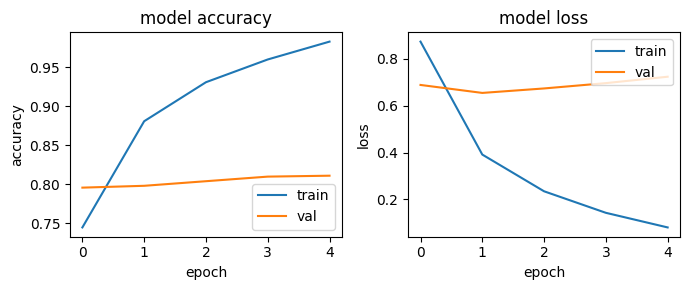

In [ ]:
# Learning curve of the model training model
def learning_curve(hist):
  plt.figure(figsize=(7, 3))
  plt.subplot(1,2,1)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='lower right')

  plt.subplot(1,2,2)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.tight_layout()
learning_curve(resnet_history)

In [ ]:
# Retrieve an Image

def predict_on_image_batches(ds, count=1, batch_size=BATCH_SIZE):
  image_batch, label_batch = next(iter(ds.shuffle(buffer_size=BATCH_SIZE).take(count)))
  # print("image batch shape", image_batch.shape)

  # # Preprocess the Image
  # image = image_batch[0].numpy()
  # batch_img = tf.reshape(image,[1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3] )
  # print("reshaped batch image shape", batch_img.shape)

  # # processing label batch
  # true_label = categories[np.argmax(label_batch[0].numpy())]
  # true_label_index = np.argmax(label_batch[0].numpy())
  # true_label = categories[true_label_index]

  # # Make Prediction
  # batch_pred = resnet_model.predict(batch_img)
  # pred = batch_pred[0]

  # # Post-process Predictions
  # predicted_label_index = np.argmax(pred)
  # predicted_label = categories[predicted_label_index]

  # Above is working / experimenting below with multiple images

  # Preprocess the Batch of Images
  batch_img = tf.reshape(image_batch, [batch_size, IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
  # print("reshaped batch image shape", batch_img.shape)

  # Processing Label Batch
  true_labels = [categories[np.argmax(label.numpy())] for label in label_batch]

  # Make Predictions
  batch_pred = resnet_model.predict(batch_img)
  predicted_labels = [categories[np.argmax(pred)] for pred in batch_pred]

  return batch_img, true_labels, batch_pred, predicted_labels


predict_on_image_batches(test_val_ds, 1)

In [ ]:
# Prediction on multiple
prediction_count = 10
batch_img, true_labels, batch_pred, predicted_labels = predict_on_image_batches(test_val_ds, prediction_count)


1/1 [==============================] - 0s 48ms/step


In this below we have 9/10 predictions correct, image 9 mislabeling a football image as a cricket image. (image 10 not seen)

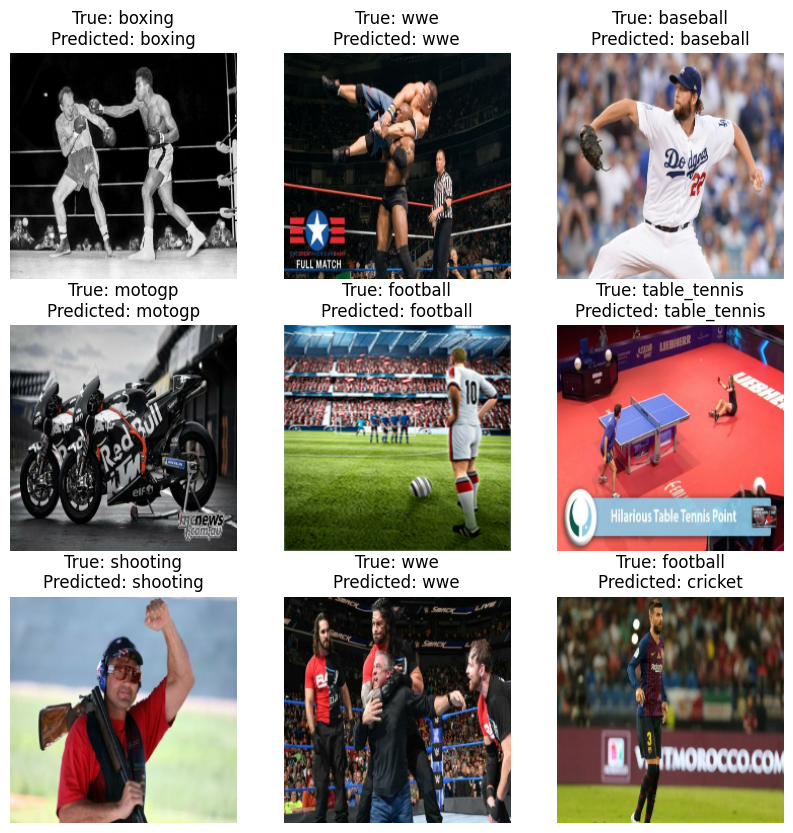

In [ ]:
# Visualization loop
rows = 3  # Number of rows in the grid
cols = 3  # Number of columns in the grid
prediction_count = min(BATCH_SIZE, rows * cols)  # Ensure not to exceed the available predictions

plt.figure(figsize=(10, 10))

for i in range(prediction_count):
    # Display the input image
    sample_image = batch_img[i].numpy()
    sample_image_resized = cv2.resize(sample_image, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
    sample_image_rescaled = sample_image_resized / 255.0
    # colored_img = cv2.cvtColor(sample_image_resized, cv2.COLOR_BGR2RGB)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(sample_image_rescaled)
    plt.title(f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]}")
    plt.axis("off")

##Appendix C

Object Detection - YOLOv8

In [ ]:
#Clone yolo 8 and check all dependencies
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 27.9/78.2 GB disk)


In [ ]:
#Train YOLO8 model
from ultralytics import YOLO
model = YOLO("yolov8n.yaml")
model = YOLO("yolov8n.pt")
model.train(data="coco128.yaml", epochs=3, verbose=False)

In [ ]:
#Test model on images from test dataset
from IPython.display import Image
metrics = model.val()

Ultralytics YOLOv8.0.225 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]


                   all        128        929      0.665      0.546      0.625      0.463
Speed: 0.4ms preprocess, 13.5ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to runs/detect/train2


In [ ]:
def obj_det(image_path):
  results = model(source=image_path,save=True, save_txt=True, project='runs/detect', name='predict', exist_ok=True)
  N = 12
  img_numb = image_path[-N:]
  return Image(filename='/content/runs/detect/predict/'+img_numb,width=600)

Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


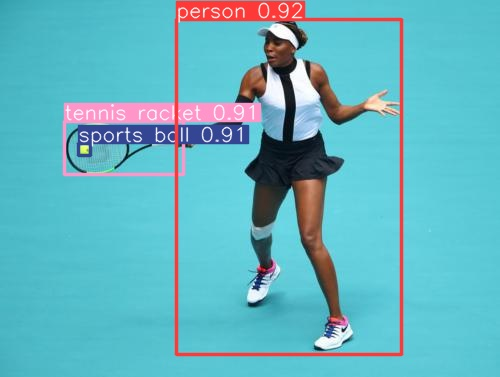

In [ ]:
obj_det('/content/kaggle_data/data/tennis/00000007.jpg')

Results saved to runs/detect/predict
2 labels saved to runs/detect/predict/labels


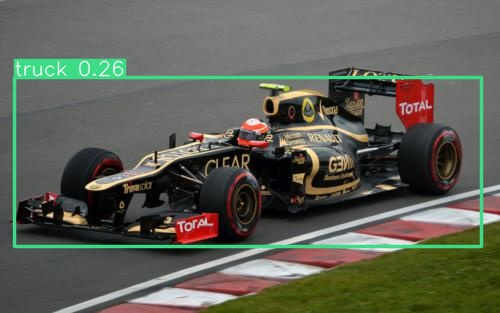

In [ ]:
obj_det('/content/kaggle_data/data/formula1/00000023.jpg')

Results saved to runs/detect/predict
3 labels saved to runs/detect/predict/labels


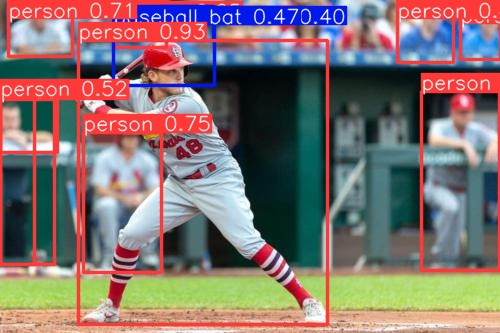

In [ ]:
obj_det('/content/kaggle_data/data/baseball/00000028.jpg')

Results saved to runs/detect/predict
4 labels saved to runs/detect/predict/labels


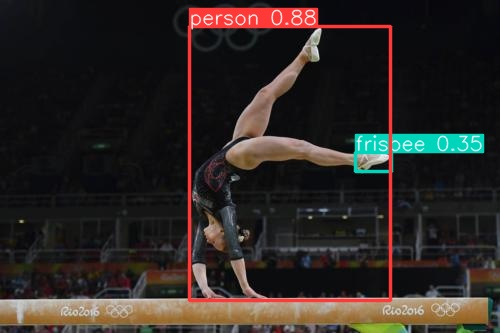

In [ ]:
obj_det('/content/kaggle_data/data/gymnastics/00000055.jpg')

Object Detection - RetinaNet

In [4]:
!git clone https://github.com/fizyr/keras-retinanet

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 6224, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 6224 (delta 6), reused 9 (delta 2), pack-reused 6205
Receiving objects: 100% (6224/6224), 13.48 MiB | 20.76 MiB/s, done.
Resolving deltas: 100% (4207/4207), done.


In [ ]:
%cd keras-retinanet
!pip install .

In [6]:
!python /content/keras-retinanet/setup.py build_ext --inplace

/usr/local/lib/python3.10/dist-packages/setuptools/__init__.py:84: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
!!

        ********************************************************************************
        Requirements should be satisfied by a PEP 517 installer.
        If you are using pip, you can try `pip install --use-pep517`.
        ********************************************************************************

!!
  dist.fetch_build_eggs(dist.setup_requires)
running build_ext
copying build/lib.linux-x86_64-cpython-310/keras_retinanet/utils/compute_overlap.cpython-310-x86_64-linux-gnu.so -> keras_retinanet/utils


In [8]:
from tensorflow import keras
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

In [9]:
#Load trained model and retinanet model and labels
model_path = os.path.join('/content/keras-retinanet', 'snapshots', 'resnet50_coco_best_v2.1.0.h5')
model = models.load_model(model_path, backbone_name='resnet50')
labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light',
                   10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow',
                   20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee',
                   30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle',
                   40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange',
                   50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed',
                   60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven',
                   70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

In [10]:
#Function to predict object classes
def retinanet_det(img_path):
  # load image
  image = read_image_bgr(img_path)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < 0.5:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)
  plt.figure(figsize=(15, 15))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

processing time:  16.611504554748535


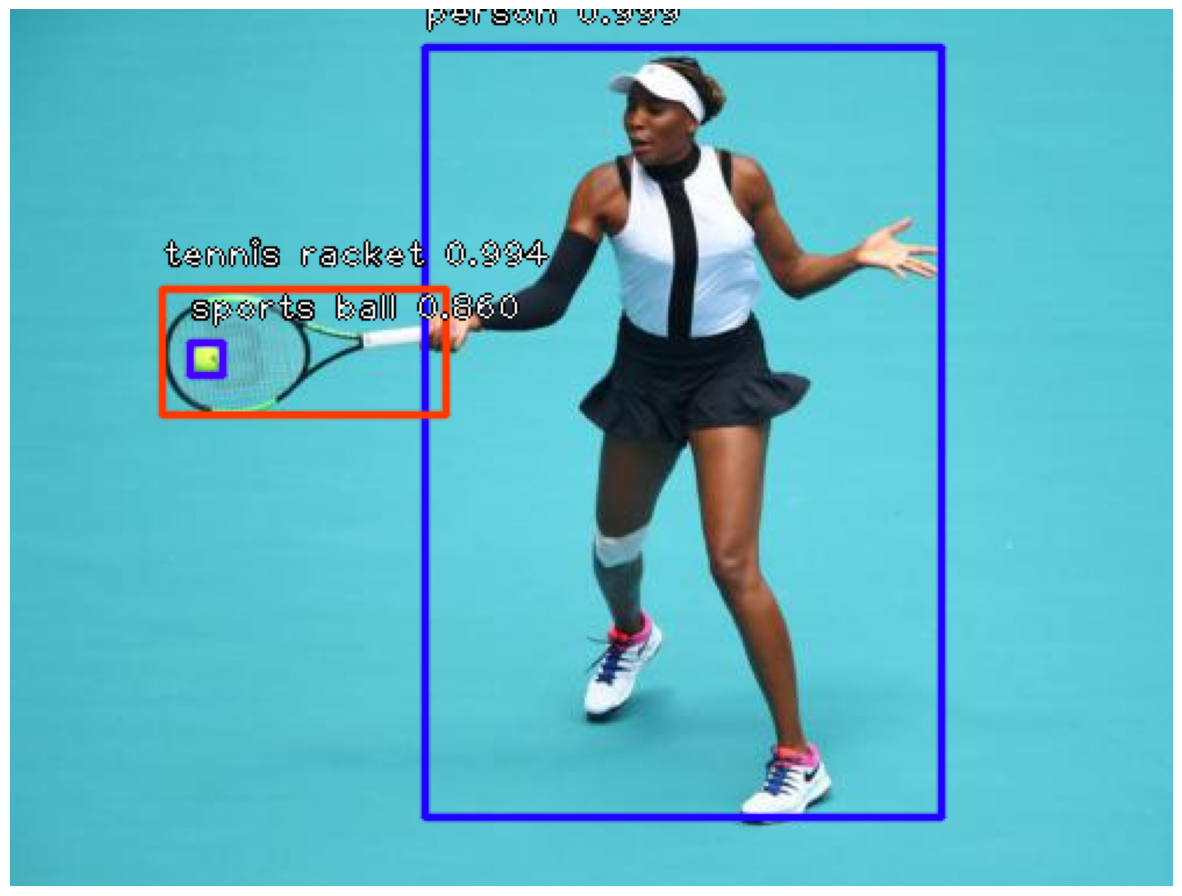

In [11]:
retinanet_det('/content/kaggle_data/data/tennis/00000007.jpg')

processing time:  7.064410209655762


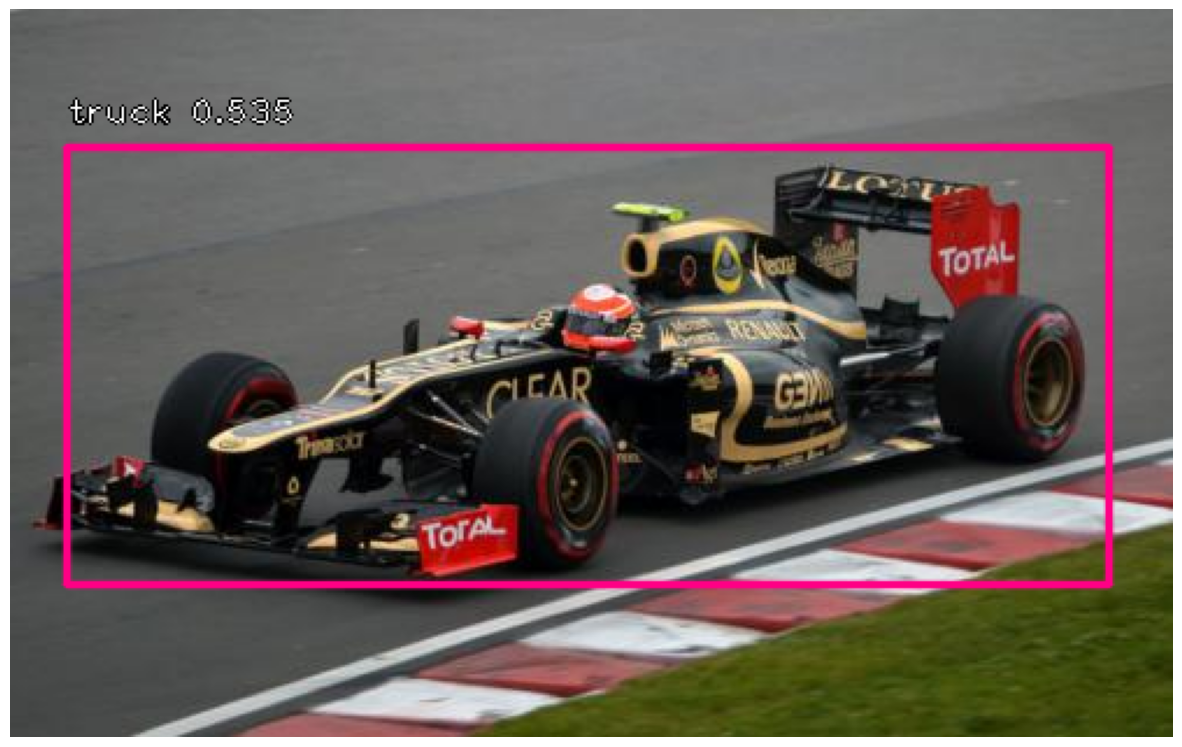

In [12]:
retinanet_det('/content/kaggle_data/data/formula1/00000023.jpg')

processing time:  2.110607624053955


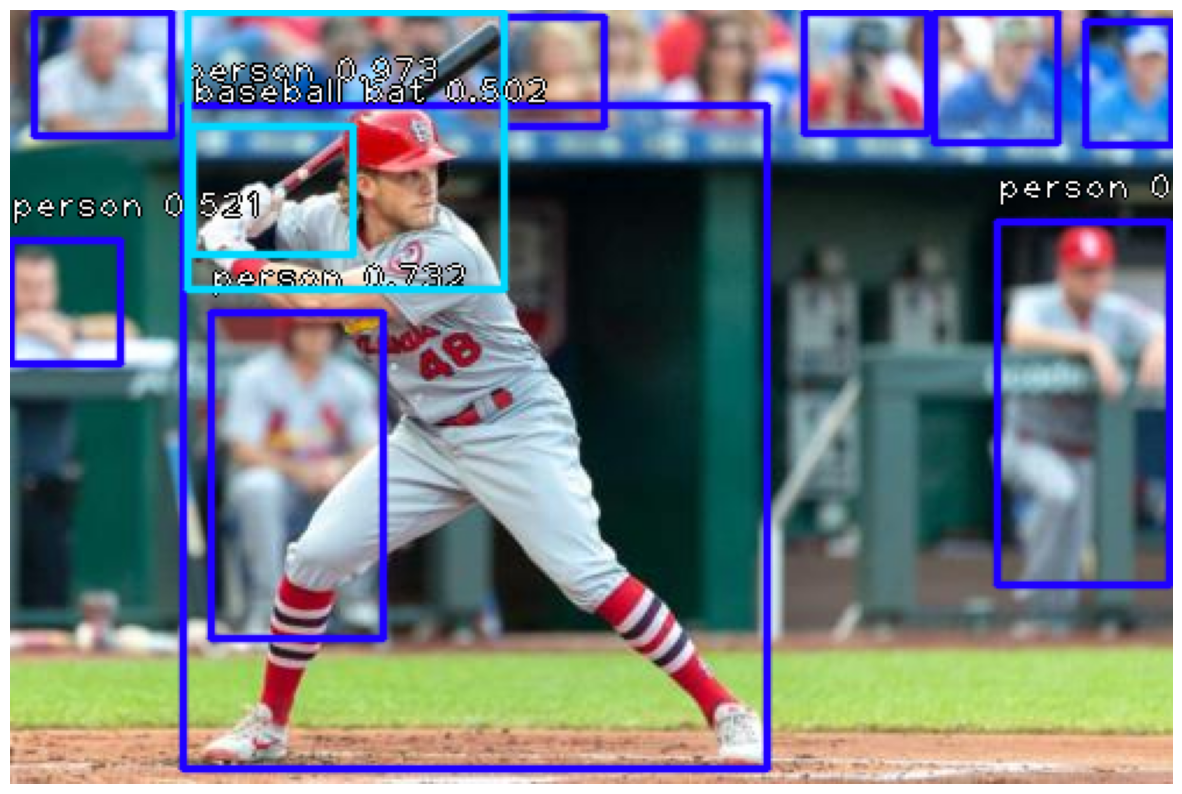

In [13]:
retinanet_det('/content/kaggle_data/data/baseball/00000028.jpg')

processing time:  0.16313862800598145


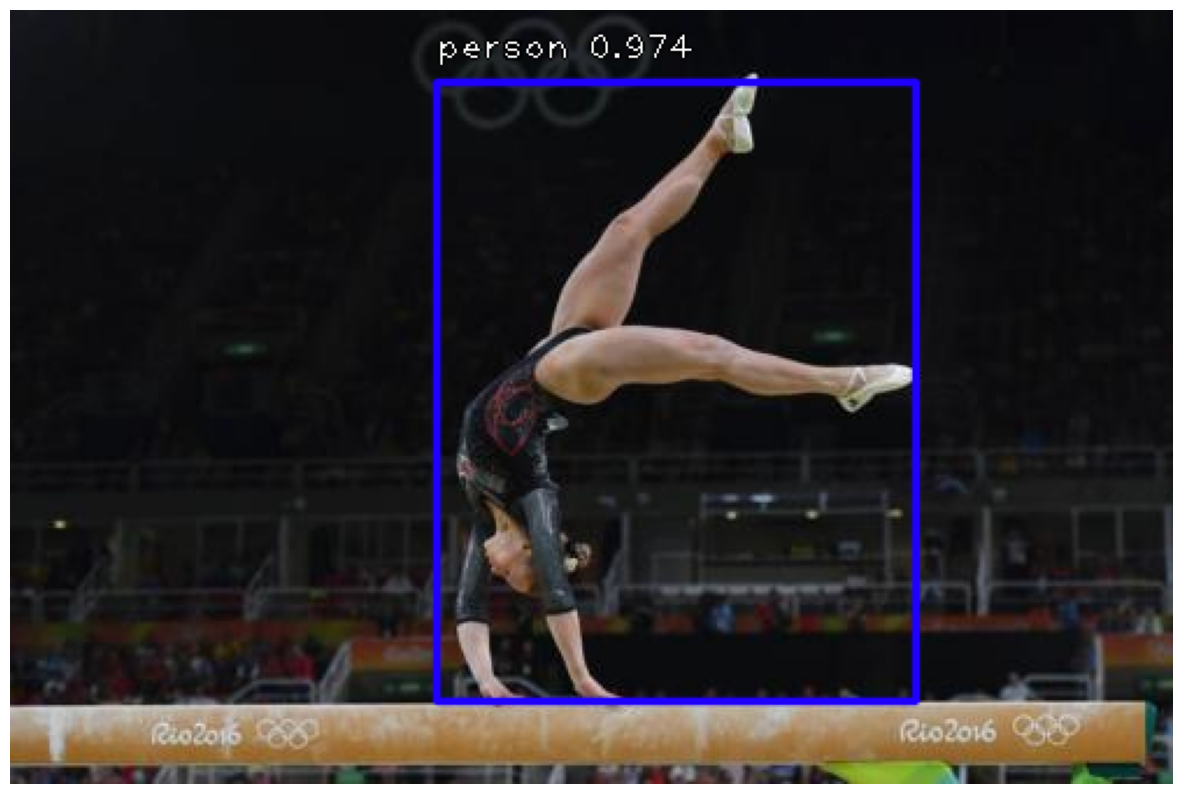

In [14]:
retinanet_det('/content/kaggle_data/data/gymnastics/00000055.jpg')

## Save with Pickle

Could be useful in saving model for application

In [ ]:
#Optional Save the x and y

In [ ]:
#dumping data into pickle file
#x_location = '/content/drive/MyDrive/Final_Project_AAI_521/data/x.pickle'
#y_location = '/content/drive/MyDrive/Final_Project_AAI_521/data/y.pickle'

#pickle file for features
#pickle_out = open(x_location,"wb") #path to save pickle file
#pickle.dump(x,pickle_out)
#pickle_out.close()

#pickle file for label
#pickle_out = open(y_location,"wb") #path to save pickle file
#pickle.dump(y,pickle_out)
#pickle_out.close()

In [ ]:
#importing data (pickle) files x and y
#pickle_in = open(x_location,"rb")   #rb - read binary form #wb - Write binary form
#x = pickle.load(pickle_in)


#pickle_in = open(y_location,"rb")   #rb - read binary form #wb - Write binary form
#y = pickle.load(pickle_in)